#  Настройка окружения и визуализация данных
 Здесь мы подключаем все необходимые библиотеки и модули, 
 без которых дальнейшая работа невозможна:
   - numpy      для эффективных численных вычислений и работы с массивами;
   - matplotlib для отрисовки графиков, чтобы визуализировать точки и разделяющие линии;
   - utils      наш собственный модуль с готовыми функциями для рисования точек и прямых.
 Затем задаём сами данные (features, labels), которые будем классифицировать.
 Функция scatter_labels сразу покажет на плоскости, какие точки относятся к классу 0, 
 а какие — к классу 1, что позволяет понять, как наши признаки могут быть разделены прямой.


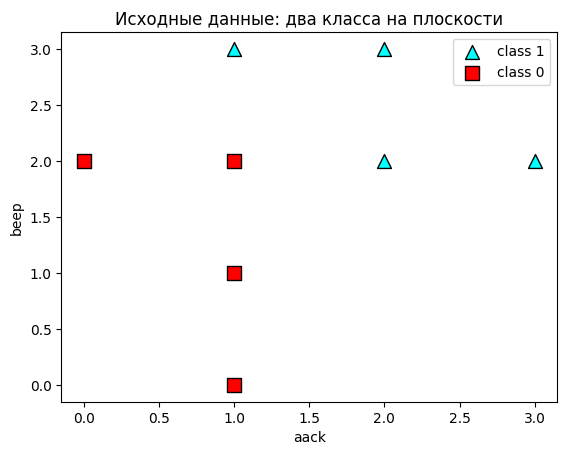

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import utils

# Данные: каждая точка двумерна, метка 0 или 1
features = np.array([[1,0],[0,2],[1,1],[1,2],[1,3],[2,2],[2,3],[3,2]])
labels   = np.array([0,0,0,0,1,1,1,1])

# Визуализируем точки двух классов задачей функции из utils
utils.scatter_labels(features, labels)
plt.title('Исходные данные: два класса на плоскости')
plt.show()

# ================================================================
# БЛОК 2: Ядро персептрона — вычисления и оценка
# Здесь описаны функции score, step, prediction, error и mean error.
# Эти функции определяют, как модель принимает решение и как мы
# оцениваем её качество на каждом примере.
# ================================================================




# Определение основных операций персептрона
 На этом этапе мы описываем математический аппарат: как модель будет
  - вычислять «score» (взвешенная сумма признаков + bias),
  - преобразовывать score в бинарную метку (0/1) через step-функцию,
  - оценивать ошибку на одном примере,
  - вычислять среднюю ошибку по всему набору данных.
 Эти составляющие — ядро алгоритма персептрона, без них обучение невозможно.

In [2]:
def score(weights, bias, feature_vector):
    return np.dot(feature_vector, weights) + bias


def step(x):
    return 1 if x >= 0 else 0


def prediction(weights, bias, feature_vector):
    return step(score(weights, bias, feature_vector))


def error(weights, bias, feature_vector, true_label):
    pred = prediction(weights, bias, feature_vector)
    return 0 if pred == true_label else abs(score(weights, bias, feature_vector))


def mean_perceptron_error(weights, bias, features, labels):
    total = sum(error(weights, bias, f, l) for f, l in zip(features, labels))
    return total / len(features)

# Правило обновления весов (perceptron trick)
 Описана компактная версия корректировки весов:
   w <- w + lr * (label - pred) * x
   b <- b + lr * (label - pred)
 Это позволяет за одну формулу обработать оба случая (недо- и пере-классификации).
 learning_rate регулирует величину шага обновления.

In [3]:
def perceptron_update(weights, bias, feature_vector, true_label, learning_rate=0.01):
    pred = prediction(weights, bias, feature_vector)
    diff = true_label - pred
    weights = weights + learning_rate * diff * feature_vector
    bias += learning_rate * diff
    return weights, bias

# Алгоритм обучения персептрона
 Здесь организован полный цикл обучения:
 1. Инициализация weights=1, bias=0 — нейтральная прямая.
 2. Для каждой эпохи:
    a) рисуем текущую разделяющую линию (пунктиром) для наглядности;
    b) считаем среднюю ошибку на всех примерах и сохраняем в history;
    c) случайно выбираем один пример и обновляем weights, bias;
 3. В конце рисуем итоговую прямую (сплошная линия) и график ошибки.
 Возвращает обученные параметры.

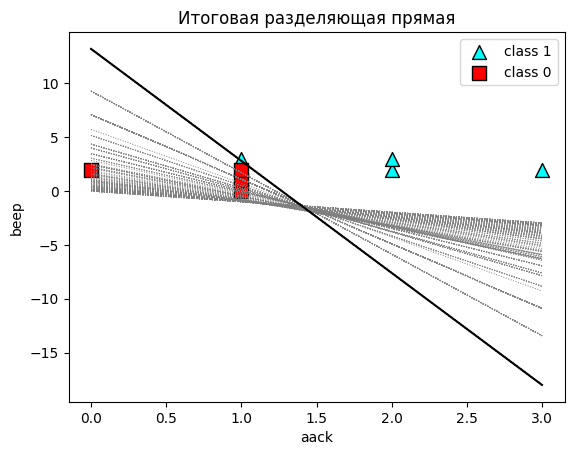

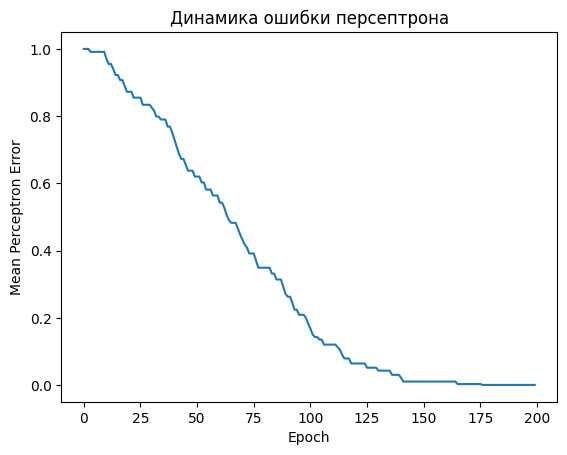

Обученные веса: [0.52 0.05]
Обученный bias: -0.6600000000000004


In [4]:
import random
random.seed(0)

def perceptron_algorithm(features, labels, learning_rate=0.01, epochs=200):
    weights = np.ones(features.shape[1])
    bias = 0.0
    error_history = []

    for epoch in range(epochs):
        # показываем текущую разделяющую прямую пунктиром
        utils.plot_linear(weights[0], weights[1], bias, color='grey', linewidth=0.7, linestyle='dotted')

        # оцениваем среднюю ошибку
        err = mean_perceptron_error(weights, bias, features, labels)
        error_history.append(err)

        # обновляем параметры по одному случайному примеру
        idx = random.randrange(len(features))
        weights, bias = perceptron_update(weights, bias, features[idx], labels[idx], learning_rate)

    # финальная разделяющая прямая
    utils.plot_linear(weights[0], weights[1], bias, color='black')
    utils.scatter_labels(features, labels)
    plt.title('Итоговая разделяющая прямая')
    plt.show()

    # график изменения ошибки
    plt.plot(error_history)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Perceptron Error')
    plt.title('Динамика ошибки персептрона')
    plt.show()

    return weights, bias

# запускаем обучение
final_weights, final_bias = perceptron_algorithm(features, labels)
print('Обученные веса:', final_weights)
print('Обученный bias:', final_bias)


# Табличный вывод (аналог tc.SFrame)
 Преобразуем массивы в pandas DataFrame, чтобы получить
 табличный вывод с возможностью сортировки и фильтрации.
 Это полностью заменяет tc.SFrame.

In [6]:
import pandas as pd

datadict = {'aack': features[:,0], 'beep': features[:,1], 'prediction': labels}
data_df = pd.DataFrame(datadict)
data_df

,aack,beep,prediction
0,1,0,0
1,0,2,0
2,1,1,0
3,1,2,0
4,1,3,1
5,2,2,1
6,2,3,1
7,3,2,1


# Логистическая регрессия методом Ньютона (IRLS)
 Здесь реализуется алгоритм Ньютона (IRLS) для логистической регрессии,
 который аналогичен тому, что делает tc.logistic_classifier.create.
 Мы вручную выводим табличку с итерациями, временем и accuracy.

In [7]:
import time
from tabulate import tabulate
from scipy.special import expit

# готовим матрицу X с единичным столбцом для bias
X_ext = np.hstack([np.ones((features.shape[0],1)), features])
y = labels

def train_logistic_newton(X, y, max_iter=10):
    n, d = X.shape
    w = np.zeros(d)
    history = []
    start = time.time()

    for it in range(1, max_iter+1):
        p = expit(X.dot(w))
        W = np.diag(p * (1 - p))
        grad = X.T.dot(y - p)
        H = X.T.dot(W).dot(X)
        delta = np.linalg.solve(H, grad)
        w += delta

        preds = (expit(X.dot(w)) >= 0.5).astype(int)
        acc = (preds == y).mean()
        elapsed = time.time() - start
        history.append([it, it+1, round(elapsed,3), round(acc,6)])
        if np.linalg.norm(delta) < 1e-6:
            break

    return w, history

w, hist = train_logistic_newton(X_ext, y, max_iter=10)
print("Logistic regression:")
print("--------------------------------------------------------")
print(f"Number of examples          : {features.shape[0]}")
print(f"Number of classes           : {len(np.unique(y))}")
print(f"Number of feature columns   : {features.shape[1]}")
print(f"Number of unpacked features : {features.shape[1]}")
print(f"Number of coefficients      : {X_ext.shape[1]}")
print("Starting Newton Method")
print("--------------------------------------------------------")
print(tabulate(hist, headers=["Iteration","Passes","Elapsed Time","Training Accuracy"], tablefmt="pretty"))
print("SUCCESS: Optimal solution found.")

Logistic regression:
--------------------------------------------------------
Number of examples          : 8
Number of classes           : 2
Number of feature columns   : 2
Number of unpacked features : 2
Number of coefficients      : 3
Starting Newton Method
--------------------------------------------------------
+-----------+--------+--------------+-------------------+
| Iteration | Passes | Elapsed Time | Training Accuracy |
+-----------+--------+--------------+-------------------+
|     1     |   2    |    0.001     |        1.0        |
|     2     |   3    |    0.002     |        1.0        |
|     3     |   4    |    0.002     |        1.0        |
|     4     |   5    |    0.002     |        1.0        |
|     5     |   6    |    0.002     |        1.0        |
|     6     |   7    |    0.002     |        1.0        |
|     7     |   8    |    0.002     |        1.0        |
|     8     |   9    |    0.003     |        1.0        |
|     9     |   10   |    0.003     |       